In [1]:
import torch
import torch.nn as nn #neural network，提供了搭建网络所需的所有组件

# 以下matplotlib为固定
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#展示高清图
# 固定
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

In [3]:
# 1.1 制作数据集
# 这里生成10000个样本，设定3个输入及输出特征
# 每个输入特征相互独立，均服从均匀分布
X1 = torch.rand(10000,1) # 输入特征1
X2 = torch.rand(10000,1) # 输入特征2
X3 = torch.rand(10000,1) # 输入特征3
X1.shape, X2.shape, X3.shape

(torch.Size([10000, 1]), torch.Size([10000, 1]), torch.Size([10000, 1]))

In [4]:
# 三个输出特征 y1, y2, y3
# 浮点型张量
Y1 = ( (X1+X2+X3)<1 ).float()
Y2 = ( (1<(X1+X2+X3)) & ((X1+X2+X3)<2) ).float()
Y3 = ( (X1+X2+X3)>2 ).float() 
Y1.shape, Y2.shape, Y3.shape

(torch.Size([10000, 1]), torch.Size([10000, 1]), torch.Size([10000, 1]))

In [5]:
# 整合数据集
Data = torch.cat([X1,X2,X3,Y1,Y2,Y3], axis=1)
Data = Data.to('cuda:0') #搬至GPU
Data.shape
# 10000行，6列

torch.Size([10000, 6])

In [6]:
# 数据的3个输出特征组合起来是一个One-Hot编码（独热编码）
# 运行一下，看到后三列：100, 010, 001
Data

tensor([[0.7056, 0.2711, 0.1086, 0.0000, 1.0000, 0.0000],
        [0.0917, 0.5212, 0.0458, 1.0000, 0.0000, 0.0000],
        [0.9121, 0.5285, 0.9045, 0.0000, 0.0000, 1.0000],
        ...,
        [0.3041, 0.7608, 0.5920, 0.0000, 1.0000, 0.0000],
        [0.2235, 0.5973, 0.9279, 0.0000, 1.0000, 0.0000],
        [0.3165, 0.8505, 0.4623, 0.0000, 1.0000, 0.0000]], device='cuda:0')

In [7]:
# 划分训练集与测试集
train_size = int(len(Data) * 0.7)    # 计算训练集样本数量，此处训练集占整个样本70%
test_size = len(Data) - train_size   # 计算测试集样本数量

# 得到数量后最好不要直接划分，有些数据可能具有先后顺序，需要打乱
Data = Data[torch.randperm(Data.size(0)) , :]   # 打乱样本顺序
train_Data = Data[:train_size, :] # 训练集样本
test_Data = Data[train_size:, :] # 测试集样本
train_Data.shape, test_Data.shape


(torch.Size([7000, 6]), torch.Size([3000, 6]))

In [8]:
# 1.2 搭建神经网络

# 以nn.Module作为父类，我们自己的神经网络可直接继承父类的方法与属性
# nn.Module 中包含 网络各个层的定义
class DNN(nn.Module):
    def __init__(self):
        # 搭建神经网络各层
        super(DNN,self).__init__()
        self.net = nn.Sequential( # Sequential：按顺序搭建各层
            nn.Linear(3, 5), nn.ReLU(),  #第1层：全连接层 （上一层节点数，这一层节点数）
            nn.Linear(5, 5), nn.ReLU(),  #第2层：全连接层
            nn.Linear(5, 5), nn.ReLU(),  #第3层：全连接层
            nn.Linear(5, 3)              #第4层：全连接层
        )
        
    def forward(self, x):
        # 前向传播
        y = self.net(x)  # x即输入数据
        return y         # y即输出数据

In [9]:
model = DNN().to('cuda:0') # 创造子类的实例，搬到GPU
model                      # 查看该实例的各层

DNN(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=5, bias=True)
    (5): ReLU()
    (6): Linear(in_features=5, out_features=3, bias=True)
  )
)

In [10]:
# 1.3 神经网络内部参数

# 权重w  偏置b
# 查看内部参数
for name,param in model.named_parameters():
    print(f"参数:{name}\n形状:{param.shape}\n数值:{param}\n")

# net0.weight权重形状[5,3]，5表示自己的节点数，3表示前一层的节点数
# device='cuda:0' 所有参数自带cuda
# requires_grad=True 张量自带的梯度计算功能

参数:net.0.weight
形状:torch.Size([5, 3])
数值:Parameter containing:
tensor([[-0.5303, -0.1797, -0.4568],
        [ 0.1023, -0.0600,  0.4397],
        [-0.1740, -0.1594, -0.3738],
        [-0.3266,  0.1557,  0.2088],
        [ 0.3504, -0.2173, -0.1513]], device='cuda:0', requires_grad=True)

参数:net.0.bias
形状:torch.Size([5])
数值:Parameter containing:
tensor([ 0.3287,  0.5557,  0.0218, -0.0668, -0.4973], device='cuda:0',
       requires_grad=True)

参数:net.2.weight
形状:torch.Size([5, 5])
数值:Parameter containing:
tensor([[-0.3391, -0.2134, -0.0058, -0.1711, -0.3276],
        [ 0.4171, -0.3472,  0.0650,  0.0625,  0.3732],
        [ 0.0904,  0.0058, -0.2958,  0.0820, -0.3371],
        [ 0.1171,  0.1736,  0.0240,  0.1279,  0.3249],
        [-0.0847, -0.1593, -0.1215,  0.2522,  0.1329]], device='cuda:0',
       requires_grad=True)

参数:net.2.bias
形状:torch.Size([5])
数值:Parameter containing:
tensor([0.4250, 0.0076, 0.4383, 0.4287, 0.3154], device='cuda:0',
       requires_grad=True)

参数:net.4.weight
形状:t

In [11]:
# 1.4 神经网络的外部参数- 超参数

# 搭建网络超参数：网络的层数，各隐藏层节点书，各节点激活函数，内部参数初始化值等
# 训练网络超参数：损失函数，学习率，优化算法，batch_size，epochs等

# 激活函数： torch内置 pytorch.org/docs/1.12/nn.html - Non-linear Activation
# 损失函数： torch内置 pytorch.org/docs/1.12/nn.html - Loss Functions
# 学习率与优化算法：pytorch.org/docs/1.12/optim.html SGD, Adam，RMSprop等
        # 优化器在模型训练阶段对模型可学习参数进行更新
        # 优化器初始化时传入模型的科学系参数，以及其他超参数如lr，momentum（？）
        # 训练过程中调用optimizer.zero_grad()清空梯度，再调用loss.backward()反向传播，最后optimizer.step()更新模型参数

In [12]:
# 选择损失函数
loss_fn = nn.MSELoss()

In [13]:
# 选择优化算法
# PyTorch实现支支持BGD或MBGD，不支持单个样本输入方式
# 此处torch.optim.SGD指标是梯度下降，具体批量与小批量（？）

learning_rate = 0.01     # 设置学习率
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)

<function matplotlib.pyplot.show(close=None, block=None)>

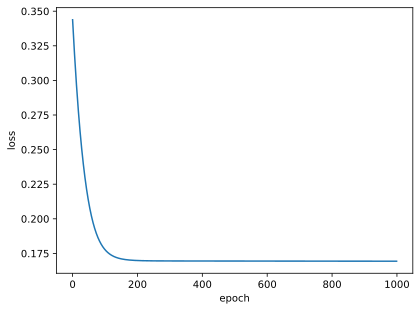

In [14]:
# 1.5 训练网络

epochs = 1000
losses = []   # 记录损失函数变化的列表，画图用

# 给训练集划分输入与输出
X = train_Data[:, :3]      # 前3列为输入特征
Y = train_Data[:, -3:]     # 后3列为输出特征

for epoch in range(epochs):
    Pred = model(X)                # 一次前向传播（BGD）记录到Pred
    loss = loss_fn(Pred,Y)         # 计算损失函数，Pred和Y之间的差异
    losses.append(loss.item())     # 记录损失函数变化 loss是张量不能直接append，降级item
    optimizer.zero_grad()          # 每轮梯度不一样，清理上一轮滞留梯度
    loss.backward()                # 一次反向传播
    optimizer.step()               # 优化内部参数

Fig = plt.figure()
plt.plot(range(epochs), losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show

In [15]:
# 1.6 测试网络

# 只需让测试集进行1次前向传播
# 过程不需要计算梯度，可以再改局部关闭梯度，使用with torch.no_grad()

In [19]:
# 给测试集划分输入与输出
X = test_Data[:, :3]      # 前3列为输入特征
Y = test_Data[:, -3:]     # 后3列为输出特征

with torch.no_grad():      # 关闭梯度计算功能，节约内存，运算速度更快
    Pred = model(X)        # 存储一次前向传播（批量）
    
    # 输出特征为独热编码，数据都是接近0或1的小数
    # 为了让预测数据与真实数据之间进行比较，要对预测数据进行规整
    Pred[:, torch.argmax(Pred, axis=1)]=1     # 将每行最大的数 = 1
    Pred[Pred!=1]=0                           # 将不是1的数 = 0
    # 最终使预测数据与真实数据格式相同
    
    # 预测正确的样本
    # Pred==Y 计算预测输出与真实输出各个元素是否相等，返回3000行 3列的boolean张量
    # (Pred==Y).all(1)检验该Boolean张量每一行的3个数据是否都是True，all(1)中的1表示按照“行”扫描，最终返回形状3000的一阶张量
    # torch.sum  看着3000个向量相加，True=1，False=0，等于预测正确的样本数
    correct = torch.sum((Pred == Y).all(1))
    
    # 全部的样本数量
    # .size(0) 第一个维度上的值是多少，这里是3000
    total = Y.size(0)
    
    print(f"测试集精准度：{100*correct/total}%")

测试集精准度：66.43333435058594%


In [17]:
# 1.7 保存网络
torch.save(model, 'model.pth')

In [18]:
# 把模型赋给新网络
new_model = torch.load('model.pth')

In [21]:
# 使用新网络（与model一致）跑测试集

# 测试网络
X = test_Data[:, :3]      # 前3列为输入特征
Y = test_Data[:, -3:]     # 后3列为输出特征
with torch.no_grad():      # 关闭梯度计算功能，节约内存，运算速度更快
    Pred = new_model(X)        # 存储一次前向传播（批量）
    Pred[:, torch.argmax(Pred, axis=1)]=1     # 将每行最大的数 = 1
    Pred[Pred!=1]=0                           # 将不是1的数 = 0
    correct = torch.sum((Pred == Y).all(1))
    total = Y.size(0)
    print(f"测试集精准度：{100*correct/total}%")

测试集精准度：66.43333435058594%
